In [1]:
import sys
import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torch import autograd

from torchvision.models import resnet18
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Normalize, ToTensor

import matplotlib.pyplot as plt
import seaborn as sbn

sbn.set_style("darkgrid")

%matplotlib inline

In [2]:
sys.path.append("../..")

from batteries import t2d, seed_all
# from batteries.layers import ArcFace

In [3]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using '{device}'!")

Using 'cuda:0'!


In [4]:
def get_transforms(dataset: str):
    """Get transforms depends from dataset.
    Args:
        dataset (str): dataset type (train or valid)
    Returns:
        dataset transforms
    """
    return Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])


def get_loaders(stage: str) -> tuple:
    """Loaders for a stage.
    Args:
        stage (str): stage name
    Returns:
        training and validation loader
    """
    trainset = MNIST(
        "./data", train=False, download=True, transform=get_transforms("train"),
    )
    testset = MNIST(
        "./data", train=False, download=True, transform=get_transforms("valid"),
    )
    train = DataLoader(
        trainset,
        batch_size=256,
        shuffle=True,
        num_workers=1,
        worker_init_fn=seed_all
    )
    valid = DataLoader(
        testset,
        batch_size=64,
        shuffle=False,
        num_workers=1
    )
    return train, valid

In [5]:
class SimpleNet(nn.Module):
    def __init__(self, n_classes: int = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, n_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

class EncoderWithHead(nn.Module):
    def __init__(self, encoder: nn.Module, head: nn.Module):
        super().__init__()
        self.encoder = encoder
        self.head = head

    def forward(
        self, images: torch.tensor, targets: torch.tensor = None
    ) -> torch.tensor:
        features = self.encoder(images)
        if targets is None:
            return features
        outputs = self.head(features, targets)
        return outputs

In [6]:
import math

class ArcFace(nn.Module):
    r"""Implement of ArcFace (https://arxiv.org/pdf/1801.07698v1.pdf):
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            device_id: the ID of GPU where the model will be trained by model parallel. 
                       if device_id=None, it will be trained on CPU without model parallel.
            s: norm of input feature
            m: margin
            cos(theta+m)
        """
    def __init__(self, in_features, out_features, s = 64.0, m = 0.50, easy_margin = False):
        super(ArcFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.s = s
        self.m = m
        
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
      
        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2)).clamp(-1.0, 1.0)
        
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        one_hot = torch.zeros(cosine.size()).to(input.device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        output *= self.s

        return output


In [13]:
seed_all(2020)

embedding_dim = 2
num_classes = 10

model = EncoderWithHead(
    encoder=SimpleNet(n_classes=embedding_dim),
    head=ArcFace(embedding_dim, num_classes),
)
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-5)

criterion = nn.CrossEntropyLoss()

In [14]:
train_loader, valid_loader = get_loaders("")
n_epochs = 2
for epoch in range(1, n_epochs + 1):
    model.train()
    train_loss = []
    for batch in train_loader:
        x, y = t2d(batch, device)
        with autograd.detect_anomaly():
            output = model(x, y)
            loss = criterion(output, y)
            train_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
            print(model.head.weight.grad)
    
        optimizer.step()
    train_loss = np.mean(train_loss)
    model.eval()
    valid_loss = []
    accuracy = []
    with torch.no_grad():
        for batch in valid_loader:
            x, y = t2d(batch, device)
            output = model(x, y)
            loss = criterion(output, y)
            torch.argmax(output)
            valid_loss.append(loss.item())
            acc = (torch.argmax(output, -1) == y).sum().detach().item()
            acc /= y.size(0)
            accuracy.append(acc)
    valid_loss = np.mean(valid_loss)
    accuracy = np.mean(accuracy)
    print(f"Epoch {epoch}/{n_epochs}: train - {train_loss:.5f}, valid - {valid_loss:.5f} (accuracy - {accuracy:.5f})")

tensor([[67.3871, 61.8413],
        [    nan,     nan],
        [12.2440, -0.5780],
        [ 4.2991,  9.3284],
        [ 7.7947,  1.4388],
        [ 0.7636, -1.1517],
        [-0.3769,  1.0705],
        [14.0739, -0.4196],
        [ 3.3615, -4.9713],
        [ 4.1475, -2.8849]], device='cuda:0')
tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]], device='cuda:0')
tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]], device='cuda:0')
tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]], device='cuda:0')
tensor([[nan, nan],
        [nan, nan],
        

In [9]:
valid_set = MNIST(
    "./data",
    train=False,
    download=True,
    transform=get_transforms("valid"),
)
valid_loader = DataLoader(
    valid_set,
    batch_size=64,
    shuffle=False,
    num_workers=1
)

model.eval()
embeddigs, labels = [], []
with torch.no_grad():
    for batch in valid_loader:
        x, y = t2d(batch, device)
        output = F.normalize(model(x))
        output = output.detach().cpu().numpy()
        embeddigs.append(output)
        labels.append(y.detach().cpu().numpy())

embeddigs = np.concatenate(embeddigs)
labels = np.concatenate(labels)

embeddigs.shape, labels.shape

((10000, 2), (10000,))

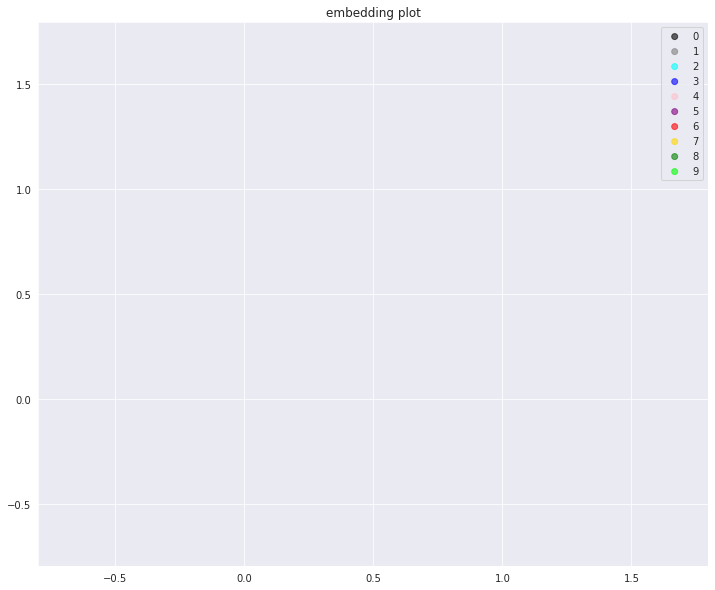

In [10]:
plt.figure(figsize=(12, 10))
color_map = {
    0: "black", 1: "grey", 2: "aqua", 3: "blue", 4: "pink",
    5: "purple", 6: "red", 7: "gold", 8: "green", 9: "lime",
}
for c in range(10):
    _map = labels == c
    plt.scatter(
        embeddigs[_map, 0], embeddigs[_map, 1],
        c=[color_map[item] for item in labels[_map]],
        alpha=0.6
    )
plt.legend(labels=[str(i) for i in range(10)])
plt.title("embedding plot");